# Testing the DistilBert fine-tuned on SST-2

In [1]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import load_dataset
import numpy as np
import evaluate
from scipy.special import softmax
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import time

In [2]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")


In [3]:
dataset_test = load_dataset("csv", data_files="books_test.csv")

In [4]:
inputs = tokenizer(dataset_test['train']['body'], truncation=True, return_tensors="pt", padding=True)

In [5]:
with torch.no_grad():
    logits = model(**inputs).logits

## Calculating accuracy, precision, F1-score

In [6]:
load_accuracy = evaluate.load("accuracy")
load_f1 = evaluate.load("f1")
labels = dataset_test['train']['label']

predictions = np.argmax(logits, axis=-1)
accuracy = load_accuracy.compute(predictions=predictions, references=labels)
f1 = load_f1.compute(predictions=predictions, references=labels)
load_precision = evaluate.load("precision")
precision = load_precision.compute(predictions=predictions, references=labels)
metrics = {"accuracy": accuracy, "f1": f1, "precision": precision}

In [7]:
print(metrics)

{'accuracy': {'accuracy': 0.79}, 'f1': {'f1': 0.832}, 'precision': {'precision': 0.9811320754716981}}


### Accuracy is 0.79, F1-score is 0.832, precision is 0.98

In [8]:
#logits of the inference on the testing data
sst_dbert_logits = logits.numpy()

## PR curve: calculating precision and recall 

In [9]:
y_true = np.array(dataset_test["train"]["label"])
sst_dbert_precision = []
sst_dbert_recall = []
sst_dbert_probabilities = softmax(sst_dbert_logits, axis=1)
threshold = list(np.arange(0.0, 1, 0.001))
for t in threshold:
    y_scores = (sst_dbert_probabilities[:, 1] > t).astype(int)
    sst_dbert_precision.append(precision_score(y_true, y_scores, zero_division=1))
    sst_dbert_recall.append(recall_score(y_true, y_scores, zero_division=1))

sst_dbert_precision.append(1)
sst_dbert_recall.append(0)

In [11]:
#precision is the most important metric as it is important for the application to avoid false positive, hence the attempts are made to preserve as high precision score as possible but also to use hight recall
for t, p, r in zip(threshold, sst_dbert_precision, sst_dbert_recall):
    if (r == 0.7638888888888888 and p == 0.9821428571428571):
        print(t, p, r)

#possible threshhold which will be used in the application 0.15<threshhold<0.266



0.15 0.9821428571428571 0.7638888888888888
0.151 0.9821428571428571 0.7638888888888888
0.152 0.9821428571428571 0.7638888888888888
0.153 0.9821428571428571 0.7638888888888888
0.154 0.9821428571428571 0.7638888888888888
0.155 0.9821428571428571 0.7638888888888888
0.156 0.9821428571428571 0.7638888888888888
0.157 0.9821428571428571 0.7638888888888888
0.158 0.9821428571428571 0.7638888888888888
0.159 0.9821428571428571 0.7638888888888888
0.16 0.9821428571428571 0.7638888888888888
0.161 0.9821428571428571 0.7638888888888888
0.162 0.9821428571428571 0.7638888888888888
0.163 0.9821428571428571 0.7638888888888888
0.164 0.9821428571428571 0.7638888888888888
0.165 0.9821428571428571 0.7638888888888888
0.166 0.9821428571428571 0.7638888888888888
0.167 0.9821428571428571 0.7638888888888888
0.168 0.9821428571428571 0.7638888888888888
0.169 0.9821428571428571 0.7638888888888888
0.17 0.9821428571428571 0.7638888888888888
0.171 0.9821428571428571 0.7638888888888888
0.17200000000000001 0.9821428571428

## Baseline model which always returns the most frequent class

In [12]:
y_score_baseline = np.ones(y_true.shape)
baseline_precision = precision_score(y_true, y_score_baseline, zero_division=1)
baseline_recall = recall_score(y_true, y_score_baseline, zero_division=1)

## Default precision/recall

In [13]:
y_score_default = logits.argmax(axis=-1)
y_scores_default = sst_dbert_probabilities.argmax(axis=-1)
default_precision = precision_score(y_true, y_score_default, zero_division=1)
default_recall = recall_score(y_true, y_score_default, zero_division=1)

## Plotting the PR curve

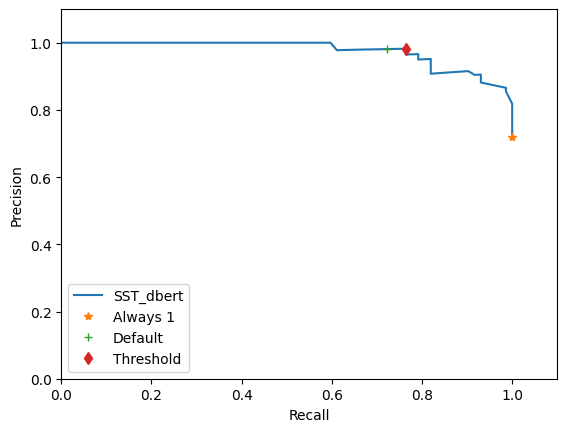

In [14]:
fig, ax = plt.subplots()
ax.plot(sst_dbert_recall, sst_dbert_precision, '-', label='SST_dbert')
ax.plot([baseline_recall], [baseline_precision], '*', label='Always 1')
ax.plot([default_recall], [default_precision], '+', label='Default')
ax.plot([0.7638888888888888], [0.9821428571428571], 'd', label='Threshold')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim((0, 1.1))
ax.set_ylim((0, 1.1))


ax.legend()

In [15]:
np.savetxt("sst_dbert_logits.csv", sst_dbert_logits, delimiter = ",")

# The model with the threshold applied which will be used in the application 

In [16]:
app_probabilities = softmax(sst_dbert_logits, axis=1)
app_threshold = 0.2
app_predictions = (app_probabilities[:, 1] > app_threshold).astype(int)

In [17]:
load_accuracy = evaluate.load("accuracy")
load_f1 = evaluate.load("f1")
labels = dataset_test['train']['label']
accuracy = load_accuracy.compute(predictions=app_predictions, references=labels)
f1 = load_f1.compute(predictions=app_predictions, references=labels)
load_precision = evaluate.load("precision")
precision = load_precision.compute(predictions=app_predictions, references=labels)
metrics = {"accuracy": accuracy, "f1": f1, "precision": precision}

In [18]:
print(metrics)

{'accuracy': {'accuracy': 0.82}, 'f1': {'f1': 0.859375}, 'precision': {'precision': 0.9821428571428571}}


## Estimating inference time

In [21]:
time_start = time.perf_counter()
model_cpu = model.to("cpu")

for text in dataset_test["train"]["body"]:
        request = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to('cpu')
        outputs = model_cpu(**request)

time_end = time.perf_counter()
    
print(f'Took {(time_end - time_start):.3f} seconds')

Took 6.737 seconds
